In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/Texas - total electricity consumption - quarterly (short tons).csv')
df.head()

,Texas - electric power (total coal consumption) - quarterly,short tons
0,2001 Q1,22164839
1,2001 Q2,22952510
2,2001 Q3,25962808
3,2001 Q4,21357650
4,2002 Q1,21917084


In [4]:
df.tail()

,Texas - electric power (total coal consumption) - quarterly,short tons
75,2019 Q4,13866538
76,2020 Q1,11029285
77,2020 Q2,12950538
78,2020 Q3,17219614
79,2020 Q4,14869537


In [5]:
df.shape

(80, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column                                                        Non-Null Count  Dtype 
---  ------                                                        --------------  ----- 
 0   Texas - electric power (total coal consumption) - quarterly   80 non-null     object
 1    short tons                                                   80 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [7]:
df.isnull().sum()

Texas - electric power (total coal consumption) - quarterly     0
 short tons                                                     0
dtype: int64

In [8]:
time = pd.date_range(start='1/1/2001',periods=80,freq='Q')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Texas - electric power (total coal consumption) - quarterly '],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [10]:
len(time)

80

In [11]:
df.head()

,short tons
time_stamp,
2001-03-31,22164839
2001-06-30,22952510
2001-09-30,25962808
2001-12-31,21357650
2002-03-31,21917084


In [12]:
df.tail()

,short tons
time_stamp,
2019-12-31,13866538
2020-03-31,11029285
2020-06-30,12950538
2020-09-30,17219614
2020-12-31,14869537


In [13]:
df

,short tons
time_stamp,
2001-03-31,22164839
2001-06-30,22952510
2001-09-30,25962808
2001-12-31,21357650
2002-03-31,21917084
...,...
2019-12-31,13866538
2020-03-31,11029285
2020-06-30,12950538


In [14]:
plt.rcParams['figure.figsize'] = [15,8]

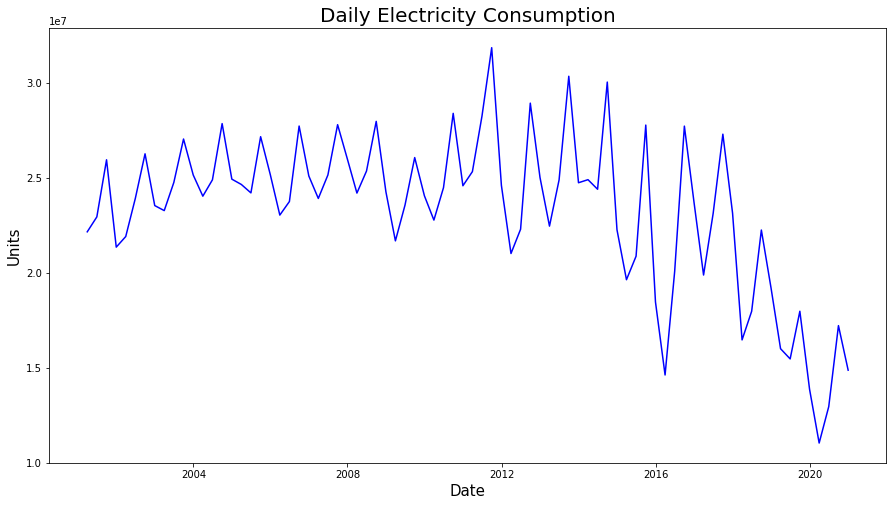

In [15]:
plt.plot(df,color='blue')
plt.title('Daily Electricity Consumption',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [16]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [17]:
#Split data set into testing dataset and train dataset
train_size = 68
train, test =df.values[0:train_size,:],df.values[train_size:len(df.values),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(64, 1, 4)
(64,)
(8, 1, 4)
(8,)


In [19]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.4 MB/s 


In [20]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [21]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('first_rnn_layer',min_value=8,max_value=128,step=8), activation="relu",return_sequences=True, input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(SimpleRNN(hp.Int(f'rnn_{i}_units',min_value=8,max_value=128,step=8),activation="relu", return_sequences=True,recurrent_dropout = hp.Choice(f"recurrent_dropout_{i}",[0.2,0.4,0.6],default=0.4)))
    model.add(SimpleRNN(hp.Int('final_rnn_layer',min_value=8,max_value=128,step=8),activation="relu",recurrent_dropout = hp.Choice("last_recurrent_dropout",[0.2,0.4,0.6],default=0.4) ))
    model.add(Dense(hp.Int('dense_layer_1',min_value=8,max_value=128,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [22]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=2,
    directory='project',
    project_name='texas_consum_2')

In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
first_rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
rnn_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
recurrent_dropout_0 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
final_rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
last_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'defau

In [24]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=8,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 47s]
val_mape: 9.294595718383789

Best val_mape So Far: 8.705847263336182
Total elapsed time: 00h 14m 01s
INFO:tensorflow:Oracle triggered exit


In [25]:
tuner.results_summary()

Results summary
Results in project/texas_consum_2
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
first_rnn_layer: 64
first_recurrent_dropout: 0.2
n_layers: 3
rnn_0_units: 48
recurrent_dropout_0: 0.2
final_rnn_layer: 40
last_recurrent_dropout: 0.2
dense_layer_1: 104
Dropout_rate: 0.30000000000000004
learning_rate: 0.0016929262285620738
rnn_1_units: 128
recurrent_dropout_1: 0.6
rnn_2_units: 64
recurrent_dropout_2: 0.4
rnn_3_units: 96
recurrent_dropout_3: 0.4
Score: 8.705847263336182
Trial summary
Hyperparameters:
first_rnn_layer: 56
first_recurrent_dropout: 0.4
n_layers: 1
rnn_0_units: 64
recurrent_dropout_0: 0.2
final_rnn_layer: 8
last_recurrent_dropout: 0.4
dense_layer_1: 104
Dropout_rate: 0.30000000000000004
learning_rate: 0.008762967221693925
rnn_1_units: 72
recurrent_dropout_1: 0.6
rnn_2_units: 72
recurrent_dropout_2: 0.6
rnn_3_units: 24
recurrent_dropout_3: 0.2
Score: 8.74471378326416
Trial summary
Hyperparameters:
first_rnn_layer:

In [26]:
from warnings import filterwarnings
filterwarnings('ignore')

In [27]:
models = tuner.get_best_models(num_models=2)
best_model = models[1]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 56)             3416      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 64)             7744      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 584       
                                                                 
 dense (Dense)               (None, 104)               936       
                                                                 
 dropout (Dropout)           (None, 104)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 105       
                                                                 
Total params: 12,785
Trainable params: 12,785
Non-traina

In [28]:
from tensorflow.keras import optimizers

In [35]:
model = Sequential()
model.add(SimpleRNN(8,activation='relu',input_shape=(1,look_back), return_sequences=True, recurrent_dropout = 0.1))
model.add(SimpleRNN(16,activation='relu',recurrent_dropout = 0.1))
model.add(Dense(80,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.0008762967221693925)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size = 8, epochs = 200)

Epoch 1/200
8/8 [==============================] - 4s 93ms/step - loss: 74.0010 - mape: 74.0010 - val_loss: 47.6351 - val_mape: 47.6351
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 39.2748 - mape: 39.2748 - val_loss: 12.5265 - val_mape: 12.5265
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 22.4272 - mape: 22.4272 - val_loss: 22.6757 - val_mape: 22.6757
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 22.8710 - mape: 22.8710 - val_loss: 22.9183 - val_mape: 22.9183
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 24.4001 - mape: 24.4001 - val_loss: 14.9203 - val_mape: 14.9203
Epoch 6/200
8/8 [==============================] - 0s 9ms/step - loss: 20.5306 - mape: 20.5306 - val_loss: 12.9248 - val_mape: 12.9248
Epoch 7/200
8/8 [==============================] - 0s 9ms/step - loss: 20.9464 - mape: 20.9464 - val_loss: 12.4175 - val_mape: 12.4175
Epoch 8/200
8/8 [==============================] - 0s 

In [33]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train MAPE : %.2f  7.256728649139404
Test MAPE : %.2f  11.091558456420898


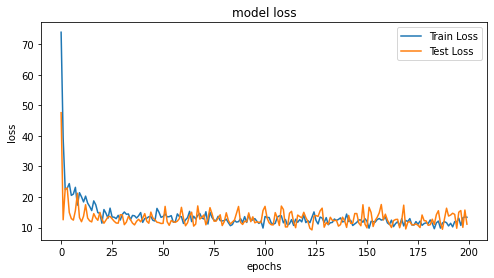

In [36]:
train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train MAPE : %.2f ',train_score[1])
test_score = model.evaluate(testX, testY, verbose=0)
print('Test MAPE : %.2f ',test_score[1])
model_loss(model_history)

In [39]:
import seaborn as sns

In [37]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(64,72)]
    plt.figure(figsize=(15,8))
    plt.plot(trainY)
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

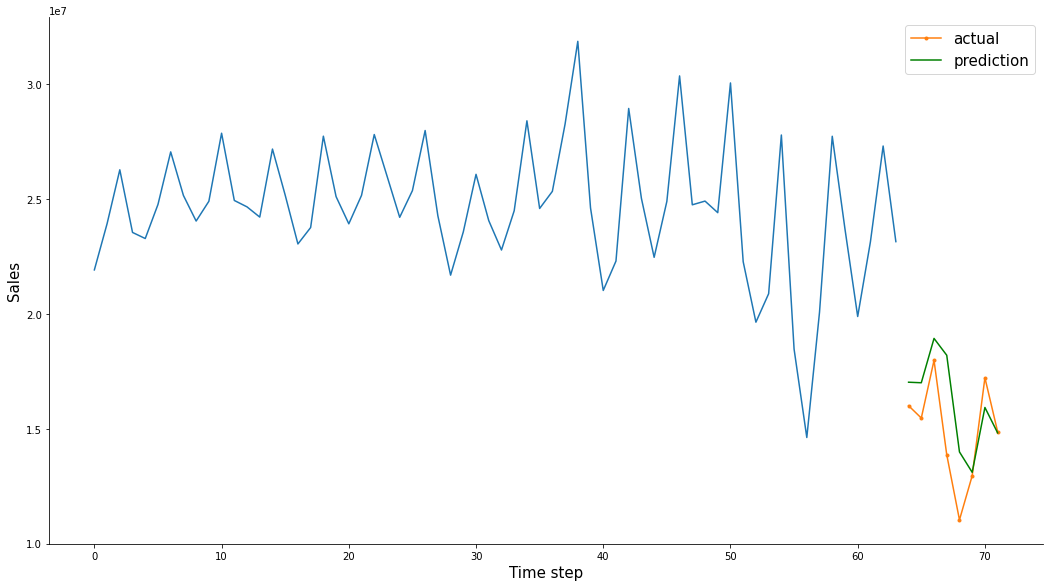

In [40]:
test_predict = model.predict(testX)
prediction_plot(testY, test_predict)